In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os 
os.chdir('..')
import fastai
from fastai.vision import *
from fastai.callbacks import SaveModelCallback
from fastai.callbacks import TrackerCallback
from fastai.callbacks import CSVLogger
from fastai.data_block import _maybe_squeeze
from fastai.callbacks import *
from utils.mxresnet import *
from utils.ranger import *
from sklearn.model_selection import StratifiedKFold, KFold
from joblib import load, dump
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from efficientnet_pytorch import EfficientNet
import pretrainedmodels
#from utils.augment import *

In [2]:
class MishFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        ctx.save_for_backward(x)
        return x * torch.tanh(F.softplus(x))   # x * tanh(ln(1 + exp(x)))

    @staticmethod
    def backward(ctx, grad_output):
        x = ctx.saved_variables[0]
        sigmoid = torch.sigmoid(x)
        tanh_sp = torch.tanh(F.softplus(x)) 
        return grad_output * (tanh_sp + x * sigmoid * (1 - tanh_sp * tanh_sp))

class Mish(nn.Module):
    def forward(self, x):
        return MishFunction.apply(x)

def to_Mish(model):
    for child_name, child in model.named_children():
        if isinstance(child, nn.ReLU):
            setattr(model, child_name, Mish())
        else:
            to_Mish(child)

In [3]:
FOLD = 2
NAME = 'EXP_60'
SUFFIX =f'STUDE_EPOCH_{FOLD}_CL1'
PATH = Path('../../../bengaliai')
SZ = 224
BS = 512
NFOLDS = 5 #keep the same split as the initial dataset
SEED = 2019
TRAIN_IMG = PATH/'img_trn_224'
LABELS = PATH/'train.csv'

os.chdir(NAME)

In [4]:
def strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = KFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

def multi_strt_split(x, y, n_folds=5, random_seed = 42, path=Path('')):  
    try: 
        val_name = load('val_idx.joblib')
    except:
        skf = MultilabelStratifiedKFold(n_splits=n_folds, shuffle=True, random_state=random_seed)
        val_name = [(val_idx, trn_idx) for trn_idx, val_idx in skf.split(x, y)]
        dump(val_name,'val_idx.joblib')
    return val_name

In [5]:
df = pd.read_csv(str(LABELS))[['image_id', 'grapheme_root']]
nunique = list(df.nunique())[1:-1]

In [6]:
val_idx = multi_strt_split(df['image_id'], df[df.columns[1:-1]].get_values())[FOLD]

/home/bukharih/.conda/envs/hb/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.values' or 'np.asarray(..)' instead.
  """Entry point for launching an IPython kernel.


In [7]:
df['image_id'] = df['image_id'].apply(lambda x: f'{str(TRAIN_IMG)}/{x}.png')
df_synt = pd.read_csv('synt_grroot_train_118604.csv')
df_synt['image_id'] = df_synt['image_id'].apply(lambda x: f'../../../bengaliai/custom_synths/img_synt_224/{x}')
new_trn_indx = np.arange(df.shape[0], df.shape[0] + df_synt.shape[0])

In [8]:
df = pd.concat([df, df_synt]).reset_index(drop=True)

In [9]:
val_idx =(val_idx[0],  np.concatenate([val_idx[1], new_trn_indx]))

In [10]:
val_idx[0].shape, val_idx[1].shape

((40168,), (279276,))

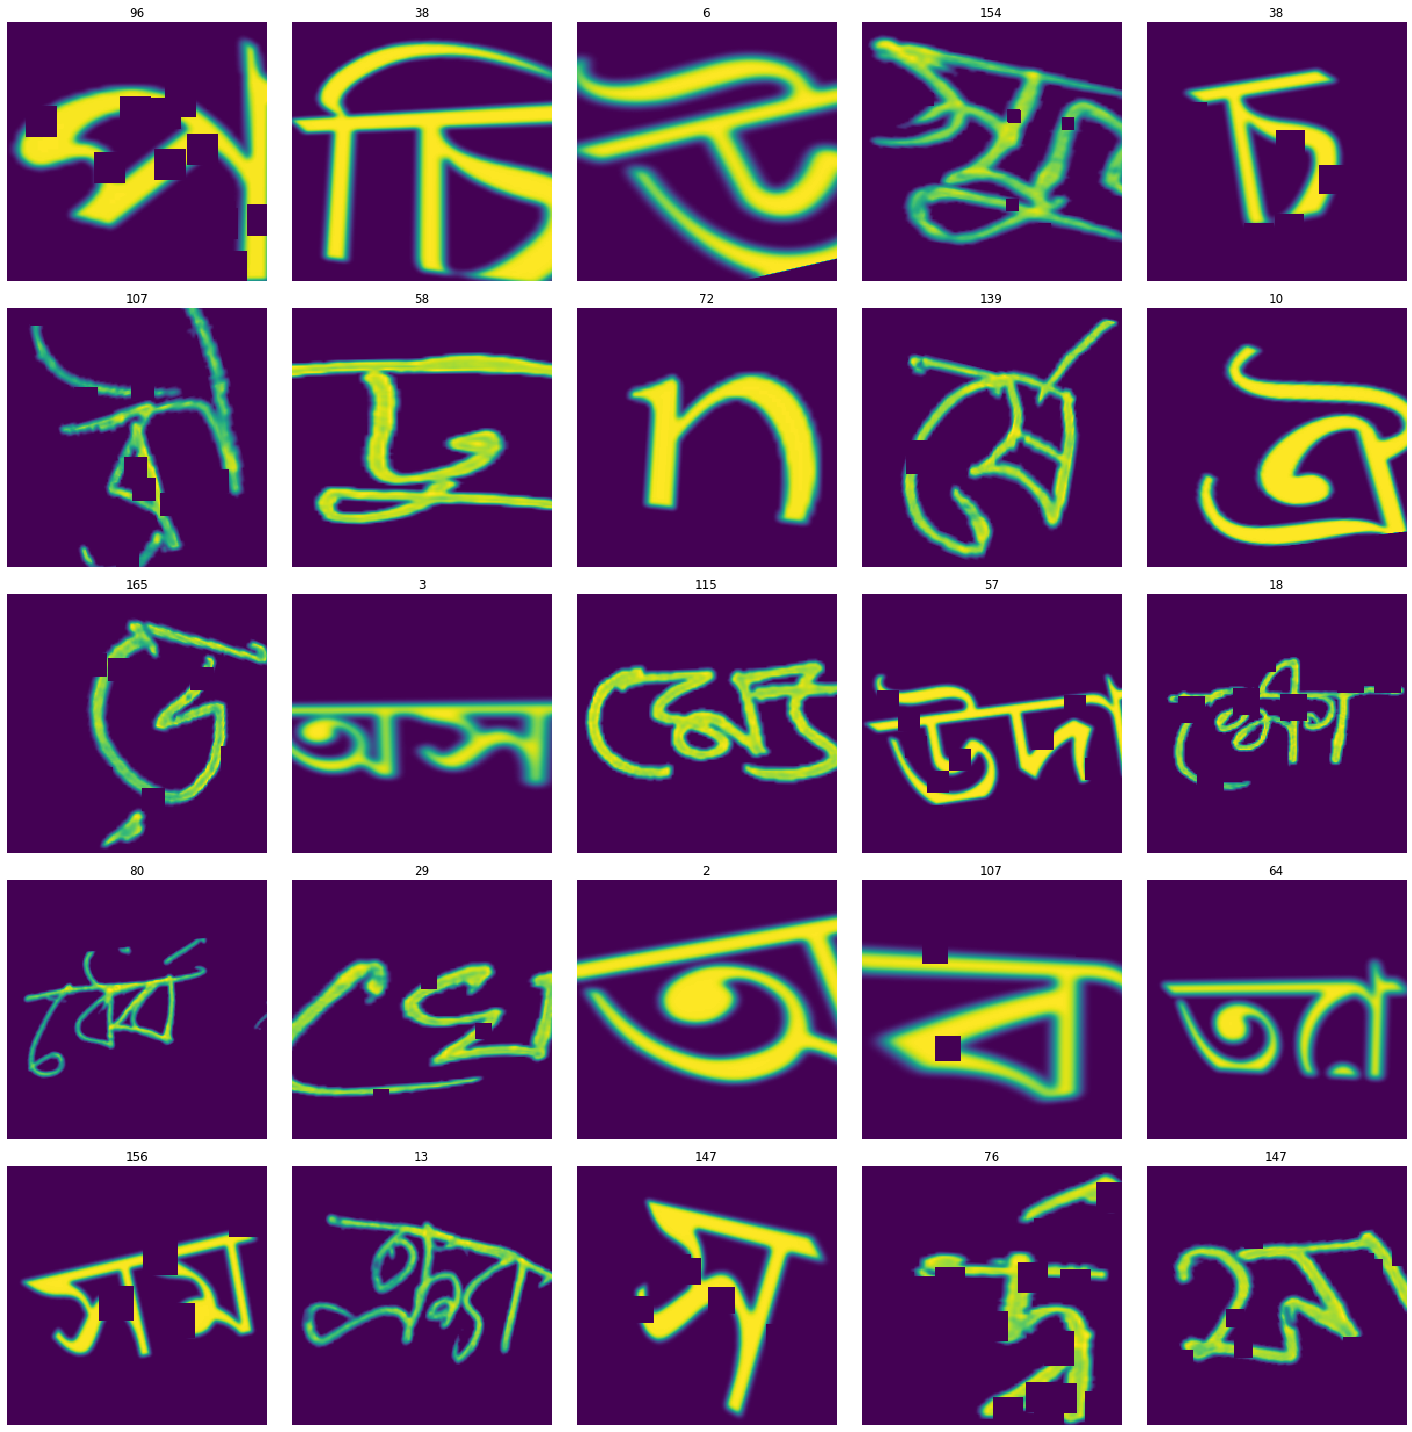

In [11]:
#imagenet_stats
data = (ImageList.from_df(df, path='', folder='', suffix='', 
        cols='image_id', convert_mode='L')
        .split_by_idxs(valid_idx=val_idx[0], train_idx=val_idx[1])
        .label_from_df(cols=['grapheme_root'])
        .transform(get_transforms(do_flip=False,max_warp=0.2, max_zoom=0.9, max_rotate=20, xtra_tfms=[cutout(n_holes=(5, 25), length=(10, 30), p=.5), squish(scale=0.66, p=0.3)]), size=SZ, padding_mode='zeros')
        .databunch(bs=BS)).normalize(([0.0692], [0.2051]))

#
data.show_batch()

In [12]:
stats_ = data.stats
stats_

([0.0692], [0.2051])

In [13]:
from fastai_extensions import *

In [14]:
from fastai.torch_core import flatten_model
from fastai.layers import CrossEntropyFlat


def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')


def get_groups(model, layer_groups):
    group_indices = [len(g) for g in layer_groups]
    curr_i = 0
    group = []
    for layer in model:
        group_indices[curr_i] -= len(flatten_model(layer))
        group.append(layer.__class__.__name__)
        if group_indices[curr_i] == 0:
            curr_i += 1
            print(f'Group {curr_i}:', group)   
            group = []

In [15]:
class Metric_idx(Callback):
    def __init__(self, average='macro'):
        super().__init__()
        self.n_classes = 0
        self.average = average
        self.cm = None
        self.eps = 1e-9
        
    def on_epoch_begin(self, **kwargs):
        self.tp = 0
        self.fp = 0
        self.cm = None
    
    def on_batch_end(self, last_output:Tensor, last_target:Tensor, **kwargs):
        last_output = last_output
        last_target = last_target
        preds = last_output.argmax(-1).view(-1).cpu()
        targs = last_target.long().cpu()
        
        if self.n_classes == 0:
            self.n_classes = last_output.shape[-1]
            self.x = torch.arange(0, self.n_classes)
        cm = ((preds==self.x[:, None]) & (targs==self.x[:, None, None])) \
          .sum(dim=2, dtype=torch.float32)
        if self.cm is None: self.cm =  cm
        else:               self.cm += cm

    def _weights(self, avg:str):
        if self.n_classes != 2 and avg == "binary":
            avg = self.average = "macro"
            warn("average=`binary` was selected for a non binary case. \
                 Value for average has now been set to `macro` instead.")
        if avg == "binary":
            if self.pos_label not in (0, 1):
                self.pos_label = 1
                warn("Invalid value for pos_label. It has now been set to 1.")
            if self.pos_label == 1: return Tensor([0,1])
            else: return Tensor([1,0])
        elif avg == "micro": return self.cm.sum(dim=0) / self.cm.sum()
        elif avg == "macro": return torch.ones((self.n_classes,)) / self.n_classes
        elif avg == "weighted": return self.cm.sum(dim=1) / self.cm.sum()
        
    def _recall(self):
        rec = torch.diag(self.cm) / (self.cm.sum(dim=1) + self.eps)
        if self.average is None: return rec
        else:
            if self.average == "micro": weights = self._weights(avg="weighted")
            else: weights = self._weights(avg=self.average)
            return (rec * weights).sum()
    
    def on_epoch_end(self, last_metrics, **kwargs): 
        return add_metrics(last_metrics, self._recall())
    
Metric_grapheme = partial(Metric_idx)

In [17]:
def se_resnext101_32x4(pretrained=True, mish=False):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    model = list(model.children())
    w = model[0][0].weight
    model[0][0] = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model[0][0].weight = nn.Parameter(torch.mean(w, dim=1, keepdim=True))
    all_layers = model
    return nn.Sequential(*all_layers[0], *all_layers[1:])

In [18]:
learn = cnn_learner(data, se_resnext101_32x4, cut=-2, split_on=lambda m: (m[0][6], m[1]), loss_func=LabelSmoothingCrossEntropy(), opt_func = Over9000, metrics=[Metric_grapheme()])
learn.mixup()
learn.to_fp16()
learn.model = nn.DataParallel(learn.model)
learn.unfreeze()
lr = 1e-2

In [19]:
learn.fit_one_cycle(15, lr, wd=1e-2,  pct_start=0.0,  div_factor=100,
                    callbacks = [SaveModelCallback(learn, every='improvement', monitor='metric_idx', name = f'{NAME}_{SUFFIX}_{FOLD}')])

epoch,train_loss,valid_loss,metric_idx,time
0,2.319418,1.892124,0.641347,17:20
1,1.944870,1.193898,0.873407,17:04
2,1.815806,1.096153,0.909572,17:02
3,1.706654,1.077430,0.915021,17:02
4,1.636338,1.025791,0.935747,17:07
5,1.597019,1.010516,0.939370,17:12
6,1.556304,1.029974,0.932706,17:12
7,1.507969,1.015379,0.935687,17:13


Better model found at epoch 0 with metric_idx value: 0.6413469910621643.
Better model found at epoch 1 with metric_idx value: 0.8734065890312195.
Better model found at epoch 2 with metric_idx value: 0.9095715880393982.
Better model found at epoch 3 with metric_idx value: 0.915020763874054.
Better model found at epoch 4 with metric_idx value: 0.9357473850250244.
Better model found at epoch 5 with metric_idx value: 0.9393696188926697.


KeyboardInterrupt: 